# Building a Computer Vision model with hugging face

<img src="https://github.com/databricks-demos/dbdemos-resources/blob/main/images/product/computer-vision/deeplearning-cv-pcb-flow-4.png?raw=true" width="700px" style="float: right"/>


Our next step as Data Scientist is to implement a ML model to run image segmentation.

We'll re-use the gold table built in our previous data pipeline as training dataset.

Building such a model is greatly simplified by using the <a href="https://huggingface.co/docs/transformers/index">huggingface transformer library</a>.
 

## MLOps steps

While building an image segmentation model can be easily done, deploying such a model in production is much harder.

Databricks simplifies this process and accelerates the Data Science journey with the help of MLFlow providing

* Auto experimentation & tracking
* Simple, distributed hyperparameter tuning with hyperopt to get the best model
* Model packaging in MLFlow, abstracting our ML framework
* Model registry for governance
* Batch or real time serving (1 click deployment)

<!-- Collect usage data (view). Remove it to disable collection. View README for more details.  -->
<img width="1px" src="https://ppxrzfxige.execute-api.us-west-2.amazonaws.com/v1/analytics?category=data-science&org_id=1549883858499596&notebook=%2F02-huggingface-model-training&demo_name=computer-vision-pcb&event=VIEW&path=%2F_dbdemos%2Fdata-science%2Fcomputer-vision-pcb%2F02-huggingface-model-training&version=1">

### A cluster has been created for this demo
To run this demo, just select the cluster `dbdemos-computer-vision-pcb-shawnzou2020` from the dropdown menu ([open cluster configuration](https://dbc-abdbb8e0-f50f.cloud.databricks.com/#setting/clusters/0410-040209-qt57lxc5/configuration)). <br />
*Note: If the cluster was deleted after 30 days, you can re-create it with `dbdemos.create_cluster('computer-vision-pcb')` or re-install the demo: `dbdemos.install('computer-vision-pcb')`*

In [0]:
%run ./_resources/00-init $reset_all_data=false $db=dbdemos $catalog=manufacturing_pcb

USE CATALOG `manufacturing_pcb`
using cloud_storage_path /Users/quentin.ambard@databricks.com/demos/manufacturing_pcb_dbdemos
using catalog.database `manufacturing_pcb`.`dbdemos`


data already existing. Run with reset_all_data=true to force a data cleanup for your local demo.


In [0]:
#Setup the training experiment
init_experiment_for_batch("computer-vision-dl", "pcb")

df = spark.read.table("training_dataset_augmented")
display(df.limit(10))

Using common experiment under /Shared/dbdemos/experiments/computer-vision-dl/pcb


filename path modificationTime length content labelDetail label 0930.JPG dbfs:/dbdemos/manufacturing/pcb/Images/Normal/0930.JPG 2024-02-23T19:25:16.000+0000 254363 List(/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjI= (truncated), iVBORw0KGgoAAAANSUhEUgAAAGQAAABkCAIAAAD/gAIDAABSrklEQVR42ky9B1tbSZo2zP9499t3d3Znenpndrrd7uCcs41tMhKgLCQQSCCRQQSRRc45i5xzzhmTDTYmOYABkzMSqb9bqm6u91yny3XOqVPhrvsJdUQ9reXr7+fh5enlLXNxc3WVurm5Sz08ZVJ3T5LigaubO/Le3r44PTy8fHz8cAYGBuHS19cfd5DK5cGenjIXFzep1AP3vfCWq9Td3RPvunt4efv4kRT1uEk98BSvIMW7/v6BaBInufTzC8AdpIHy4KDgUHlQiH+A3M8/0EvmgzuoBDW4uErRMdwn/QkNDQ8JCQsKCkGvUC15HRm0jjzOsLAIPJLJfHATebyFTgYEyPEI3UaKnqvHqRlPQECAH94PCJBKpa6urt6aIygoCPV6enpqoQkgI/PxBkwADqnM28fXLwD9c3LGiD3t7B1l3r52dg5oEn3y0lRL4MBJIMNoycjRRWTIU3QCGVIJxoY6vTWdJrCiADrt5OSCPF5HikcYuVSDphpTmQ/axYm31GPx8cNN1OPj66+ux9tXjWlgEHqVkJAUGxsfHR2LS8CBFFjgRMfQFhDBSfp58RRvkelHJcj7+fnjPwwsODg4PDwcuGAM/pojMBBwh8nl8sjISC2MDhgBMvDL3tFBM1gZuuLo5OKMAXj7gh0Ojs54C4MBFmRmMB6czs6uuInGyB08xZiRQQ/UA3ZzB1KoBykYgaqQojD6elEDmXDUQ8qjbcCHMkAKtAK+AYFByIBTZP4I0cIjotTUCwoJD49Ef1BhVFQMEEG7JAXXUC0K4ETPkZJiaA55giORD8JHX1/MogyzB3QAE4bk4eGBO5hJmWaErpq51fL29ZF6uGOmARZeBLNcXN0wh4TwEjsHgIWxYYqQ4kUMyVMjlYDmQnwcHZ2DITXyYBRAMfIIEKCkvYMTxonRAiyMkIgPERMigBgMXkENmlny+UPYMdTgUBQGUgSvsPBIZIhIEqIRUSJYgJJEP+B1ggI6gy7hEn0ggokMUrxF2IQy5L56brxkgAm4gEcAi7AMSAEyZMA1PAL/tTRQuKulz8cbM+3s6uLs6obeoE+ADEhhtGS2kaI9QHwhbgQ1AhAK4BL3IbASiT2QQgEIoJqVAXLCLO8/lR0egYMoTLQMmQPUQHQiagOpgS8wQk8IRgQyZFAJeiXTgEJeJwRB68gANVQLFHCJagENmUKiVXGiPCYY+F5IMV7BnGACIX2AJjQ0lDCLHAAOj4AgsNci2p2IIZBSpy5qqSG6GeSCEBFtLRLZEoDQAC6BHREccjo4OKEYkAJMyP8hYui0lzeBnugaZPCI4ILyBGhCB8BH1BxuQnjROmYL74KPwAgnISb6FhwSFqiBgAg1GBQREUUYSrQBAQt5pESZkjsa3a3mI+Eg0XF4HaIEUAAWcAHG7u7uQM3ZGWT3kGsoitdwqQWFha6ih8AhQB4Ifnl6ycjwkAIsQgo0TLgAjDTKG8rFWSKxAzlBPGdnF0dHRzSmyTjZ29ujPQwOeLuguCt0HwiCAfvDehCKEVWNKUEK1uBEWwRZMlVoDvPkqVFtahJp9BceEfFE94iFlWn0NIEP1CM14yYBmrxO+KiWPggdDLFGcwVpChPhVQuIn6/UXRoUEgzd7ukFZ0ANHCADdkTTAy8tot0hiYAMkwGwwsIjCM+J6xCgkW3whWguom5wSWwtBBu4ACZkgD2wA2OhC5HCfGBmnDQGDy0RZRkcEkqsGwZPUENKNBqaI0bARWNJiVLD2wQstRCBNRq6kROXeAU9DgkNJ7NLSHeh19SiqpkPVIh8KPwGQm3ZHxNGVA3qhHOEf8kbQACYyIOCMAR0GGMEuSDqGK8WPBuUAKeIJAIvODlo1V2jZYlzhDpAXaIjCbHBINSCyUKNYA4QAZuEQiH4BYCAGmkJKWBCMyhAwEVdZA4IZOgraQKpVOOXqafrTyHF9BBJB3Ayzf2LKcQrEFXkiYQSnmJeSbXkJuEXeQsnnmJQxM5eKGUoR1ASIoPha3SgH3EPgAkAQoehwjAKjAgyrwU9BUSJgkdpaFK0qrZZmjZIt9BjtYdJ/EyNosFYQSIPjU+FMTloDjs7O4BC8kANIBJ59PzzQJOomlCATDsawhguZgUnGOen0cFACroPVlKt751d1e6FposAiJS5IBryuElO5PGU0BaXBEHCNaJACQ/IbOEmkX0QG6SBs0TUERgDScTsQvpCQkKAGhmpFpwGtdeuUfPwXZA6ObuoDbNmltCeWGJPnE/iPUKFazIATn0AF/DLxsaGiCEugRHRX0AKN5E6aQ60h/LQaGTa/+yl2nWCHJHB4yQIQvCJJ0HMiNrv1cgLGSoZOaEYLonWJ1bSXWOCSQHcQStqEwwdHRJGBkV0FoGbME7jS0oxd8Q5h9UlXhQkA6MAXkR5YVxqpxQyCH45OjsR+nlotAMqJXJBCK/hh+zC8UU3URdQRxVE7gATqR10BUaoHYgCNYBlpzmAFx7hPQwbnSauHKmfnGiRMMtVgw4xZ8S599Ssk4gjQlxcgIKlBS5xMyo6FuMnVQEdAgfRSheyeZHHiyhJbAVZh2moFwDGELCAFHCAilH31tMTE4zhEH2i5SaFV+Xl5OwksrGBeoBRwMyCNzD1arXjjU5IYe6Qx+CAEaiB6VPPIN5yciL8wgMII6ARiURExxN1TjCSSCSEYmrZdHPxgFLwDZDJoLPh0AI9LzjXYANOmDIXtaby0DiK4BHYh746o110iZha+MwOjk7omaPGHCONi08ATupHLq4QCzhNONUmww/oq5UnuYMXMSjgQu6QR6hBqrYvMG0y2GtvH1AVag4mBUsL+IMe6A4GSBx6LQwDD8i0u2mUE+6SESIlEKilTioFfYiIETYho3Ea1DdRAG9BHpFx0TgLKEBWfcAIqa2tLW7ijgM8VomN2my6AlB0wt1N6izz9YY28PH3IwR383DXmF2ofzUgrm7QXGrvBAYE/EWLYrGYtI7xIMVUOfx5kA4QwYGuIaPDoIgtImsXMp3EO0cBFCOOKIoRBpGx+GpcXlIhmlB78B4awqAHGBWKohNE+xAbRwyZ658HcQ5QBhkCH4GJQIw7eJeAi5bQPPIgF54ixUhQG8wALKemB8AEjoWDu4crFISzizOkALLgKnUDcM5OrnZ29lIp1ttqxO3sIM5/AEEQIXm0eKENiakhM4SuYpykgJdm6Y9ihARIAQcAwiNgRPqP3hLnAG+RsZCFNHmXkAtj0ULbZDAEI2L+kSE+PubwglbE9qNScANASDUH0d8+mgMF0G+yACE9A6GIskcrMAJ40dnJ0dXFycnR3tZGBFaJhFZCa4G5OUcisXVxUdtSgcCCx+MKrURODs5uLlJrgdDBztHZEWC6EA0ISUdVgAPdJhQmYkJgQj/RCmmUyBEpQz62oCTpOVnKoAyRLzzy0hykNvQfzCKEwkHMunohjWdEmojEoSW8Y2lpSYiHioiuIdrnT1FyIDxCjaRbnpqVGMrjEcmjo0SoUTMgI3wE9FJMu5Oj1MXB3c3BzdneyoJHMzWxtrIQi0VqEXS2t7Qwt+Bzbawt7cVie7GdJc/Cksd3sLO1t5cAIwGwtLCwtrYmxCcScKFZ0DrpHlEXH

## Create our Dataset from the delta table

Hugging face makes this step very easy. All it takes is calling the `Dataset.from_spark` function. 

Read the <a href="https://www.databricks.com/blog/contributing-spark-loader-for-hugging-face-datasets">blogbost</a> for more detail on the new Delta Loader.

In [0]:
from datasets import Dataset

dataset = Dataset.from_spark(df).rename_column("content", "image")

splits = dataset.train_test_split(test_size=0.2, seed = 42)
train_ds = splits['train']
val_ds = splits['test']

Dataset spark downloaded and prepared to /root/.cache/huggingface/datasets/spark/1888161624/0.0.0. Subsequent calls will reuse this data.


## Transfer learning with Hugging Face

Transfer learning is the process of taking an existing model trained for another task on thousands of images, and transfering its knowledge to our domain. Hugging Face provides a helper class to make transfer learning very easy to implement.


The classic process is to re-train the model or part of the model (typically the last layer) using our custom dataset.

This provides an the best tradeoff between training cost and efficiency, especially when our training dataset is limited.

In [0]:
import torch
from transformers import AutoFeatureExtractor, AutoImageProcessor

# pre-trained model from which to fine-tune
# Check the hugging face repo for more details & models: https://huggingface.co/google/vit-base-patch16-224
model_checkpoint = "google/vit-base-patch16-224"

#Check GPU availability
if not torch.cuda.is_available(): # is gpu
  raise Exception("Please use a GPU-cluster for model training, CPU instances will be too slow")

In [0]:
from PIL import Image
import io
from torchvision.transforms import CenterCrop, Compose, Normalize, RandomResizedCrop, Resize, ToTensor, Lambda

#Extract the model features (contains info on the pre-process step required to transform our data, such as resizing & normalization)
#Using the model parameters makes it easy to switch to another model without any change, even if the input size is different.
model_def = AutoFeatureExtractor.from_pretrained(model_checkpoint)

normalize = Normalize(mean=model_def.image_mean, std=model_def.image_std)
byte_to_pil = Lambda(lambda b: Image.open(io.BytesIO(b)).convert("RGB"))

#Transformations on our training dataset. we'll add some crop here
train_transforms = Compose([byte_to_pil,
                            RandomResizedCrop((model_def.size['height'], model_def.size['width'])),
                            ToTensor(), #convert the PIL img to a tensor
                            normalize
                           ])
#Validation transformation, we only resize the images to the expected size
val_transforms = Compose([byte_to_pil,
                          Resize((model_def.size['height'], model_def.size['width'])),
                          ToTensor(),  #convert the PIL img to a tensor
                          normalize
                         ])

# Add some random resizing & transformation to our training dataset
def preprocess_train(batch):
    """Apply train_transforms across a batch."""
    batch["image"] = [train_transforms(image) for image in batch["image"]]
    return batch

# Validation dataset
def preprocess_val(batch):
    """Apply val_transforms across a batch."""
    batch["image"] = [val_transforms(image) for image in batch["image"]]
    return batch
  
#Set our training / validation transformations
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

/databricks/python/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [0]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

#Mapping between class label and value (huggingface use it during inference to output the proper label)
label2id, id2label = dict(), dict()
for i, label in enumerate(set(dataset['label'])):
    label2id[label] = i
    id2label[i] = label
    
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Fine tuning our model 

Our dataset and model is ready. We can now start the training step to fine-tune the model.

*Note that for production-grade use cases, we would typically to do some [hyperparameter](https://huggingface.co/docs/transformers/hpo_train) tuning here. We'll keep it simple for this first example and run it with fixed settings.*


In [0]:
model_name = model_checkpoint.split("/")[-1]
batch_size = 32 # batch size for training and evaluation

args = TrainingArguments(
    f"/tmp/huggingface/pcb/{model_name}-finetuned-leaf",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=1,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=20,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=False
)

In [0]:
import numpy as np
import evaluate
# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.

# Let's evaluate our model against a F1 score. Keep it as binary for this demo (we don't classify by default type)
accuracy = evaluate.load("f1")

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=eval_pred.label_ids)

In [0]:
import mlflow
import torch
from transformers import pipeline, DefaultDataCollator, EarlyStoppingCallback

def collate_fn(examples):
    pixel_values = torch.stack([e["image"] for e in examples])
    labels = torch.tensor([label2id[e["label"]] for e in examples])
    return {"pixel_values": pixel_values, "labels": labels}

#Make sure the model is trained on GPU
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

#mlflow.autolog(log_models=False)
with mlflow.start_run(run_name="hugging_face") as run:
  early_stop = EarlyStoppingCallback(early_stopping_patience=10)
  trainer = Trainer(model, args, train_dataset=train_ds, eval_dataset=val_ds, tokenizer=model_def, compute_metrics=compute_metrics, data_collator=collate_fn, callbacks = [early_stop])

  train_results = trainer.train()

  #Build our final hugging face pipeline
  classifier = pipeline("image-classification", model=trainer.state.best_model_checkpoint, tokenizer = model_def, device_map='auto')
  #log the model to MLFlow
  reqs = mlflow.transformers.get_default_pip_requirements(model)
  mlflow.transformers.log_model(artifact_path="model", transformers_model=classifier, pip_requirements=reqs)
  mlflow.set_tag("dbdemos", "pcb_classification")
  mlflow.log_metrics(train_results.metrics)

/databricks/python/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.118000,0.115240,0.819599
2,0.225600,0.056769,0.952191
3,0.071600,0.160032,0.849758
4,0.112800,0.023221,0.988722
5,0.012200,0.006676,0.992366
6,0.047200,0.026022,0.976654
7,0.051300,0.010514,0.990440
8,0.033500,0.001423,1.000000
9,0.077700,0.004259,0.996183
10,0.012000,0.005637,0.994264


/databricks/python/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
2024/03/04 22:08:19 WARNING mlflow.utils.requirements_utils: Found torch version (1.13.1+cu117) contains a local version label (+cu117). MLflow logged a pip requirement for this package as 'torch==1.13.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/03/04 22:08:19 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.14.1+cu117) contains a local version label (+cu117). MLflow logged a pip requirement for this package as 'torchvision==0.14.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `

predictions: [{'score': 0.999804675579071, 'label': 'damaged'}, {'score': 0.00019532146689016372, 'label': 'normal'}]


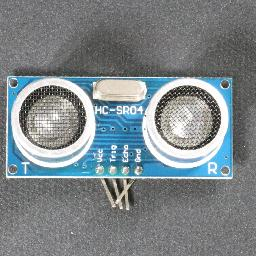

In [0]:
test = spark.read.table("training_dataset_augmented").where("filename = '010.JPG'").toPandas()
img = Image.open(io.BytesIO(test.iloc[0]['content']))
print(f"predictions: {classifier(img)}")
img

## Model deployment

Our model is now trained. All we have to do is save it in our Model Registry and move it as Production ready. <br/>
For this demo we'll use our lastes run, but we could also search the best run with ` mlflow.search_runs` (based on the metric we defined during training).

In [0]:
#Save the model in the registry & move it to Production
model_registered = mlflow.register_model("runs:/"+run.info.run_id+"/model", "dbdemos_pcb_classification")
client = mlflow.tracking.MlflowClient()
print("registering model version "+model_registered.version+" as production model")
#Move the model as Production
client.transition_model_version_stage(name = "dbdemos_pcb_classification", version = model_registered.version, stage = "Production", archive_existing_versions=True)

Registered model 'dbdemos_pcb_classification' already exists. Creating a new version of this model...
2024/03/04 22:08:28 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: dbdemos_pcb_classification, version 24


registering model version 24 as production model


Created version '24' of model 'dbdemos_pcb_classification'.


<ModelVersion: aliases=[], creation_timestamp=1709590108740, current_stage='Production', description='', last_updated_timestamp=1709590121137, name='dbdemos_pcb_classification', run_id='58ed1772e1c24f5197d229497ecfb023', run_link='', source='dbfs:/databricks/mlflow-tracking/2029433254544539/58ed1772e1c24f5197d229497ecfb023/artifacts/model', status='READY', status_message='', tags={}, user_id='7644138420879474', version='24'>

## Next: Inference in batch and real-time 

Our model is now trained and registered in MLflow Model Registry. Databricks mitigates the need for a lot of the anciliary code to train a model, so that you can focus on improving your model performance.

The next step is now to use this model for inference - in batch or real-time behind a REST endpoint.

Open the next [03-running-cv-inferences notebook]($./03-running-cv-inferences) to see how to leverage Databricks serving capabilities.